In [2]:
import scienceplots
import matplotlib.pyplot as plt

import matplotlib.colors as colors
from matplotlib.patches import Patch
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

plt.style.use("science")

In [4]:
X = np.load("../data/normalised_objs.npy")
encoded = np.load("../data/encoded_objs.npy")
decoded = np.load("../data/decoded_objs.npy")

recon_losses = np.sum((X - decoded)**2, axis=1)
del decoded, X

In [6]:
data = pd.read_csv("../../dp03/dp03_objects.csv")
# Clean
data["a"] = data["q"]/(1 - data["e"])

clean_objs = data.dropna()
clean_objs = clean_objs.drop(columns=["ssObjectId", "fullDesignation", "q2", "e2", "Unnamed: 0"])

clean_objs["i-z"] = clean_objs["i_H"] - clean_objs["z_H"]
clean_objs["g-r"] = clean_objs["g_H"] - clean_objs["r_H"]
clean_objs["r-i"] = clean_objs["r_H"] - clean_objs["i_H"]

clean_objs["a*"] = .89*(clean_objs["g-r"]) + .45*(clean_objs["r-i"]) -.57

clean_objs["a"] = clean_objs["q"]/(1-clean_objs["e"])

clean_objs["Q"] = clean_objs["a"]*(1 + clean_objs["e"])
clean_objs["T_jup"] = (5.204/clean_objs["a"]) + 2*np.cos((clean_objs["incl"]/180)*np.pi)*np.sqrt((clean_objs["a"]/5.204)*(1 - clean_objs["e"]**2))

print((len(data) - len(clean_objs))/len(data)) # Dropped

0.30126084082016896


In [7]:
nn = NearestNeighbors(n_neighbors=20).fit(encoded)

In [8]:
anoms = []

for obj in np.argsort(recon_losses)[-10::][::-1]:
    kn_idx = nn.kneighbors([encoded[obj]])
    
    anoms.append(
        kn_idx[1][0]
    )
    
#iso_index = np.argsort(recon_losses)[-20::][::-1][5]

#kn_idx = nn.kneighbors([encoded[iso_index]])

In [13]:
print(data.loc[clean_objs.iloc[np.argsort(recon_losses)[-10::][::-1], :].index, :]["fullDesignation"])

1425257     2011 S0000mXTa
2335387     2011 S0000qYqa
866937      2011 S00015fxa
1130166     2011 S102qW9Ma
838704      2011 S0000sEwa
3361266    2011 iso0007163
1369289      2011 LPCC3251
2748717      2011 LPCD1330
4344516      2011 LPCC2991
3938451     2011 S10cb6d8a
Name: fullDesignation, dtype: object


In [14]:
df = pd.DataFrame(
    encoded,
    columns = [f"AE {i}" for i in range(1,7)]
)

df["cluster"] = 0
for i, clst_idx in enumerate(anoms):
    df.loc[clst_idx, "cluster"] = i + 1

/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_7247/2268845023.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


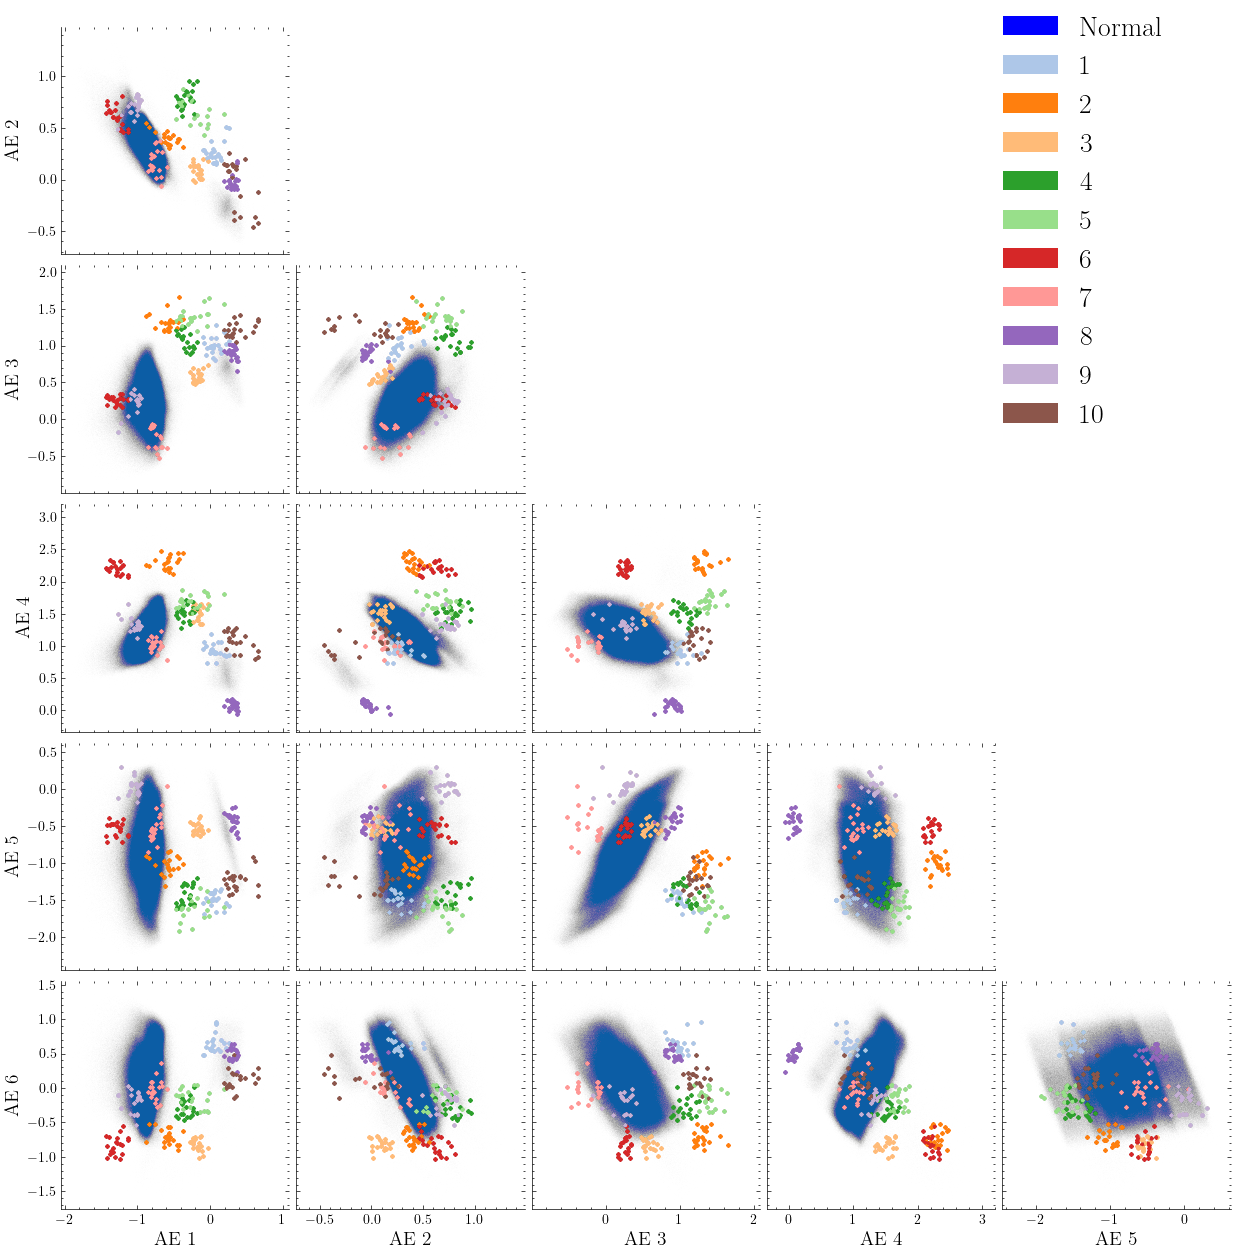

In [15]:
values = np.arange(11)

# Choose a discrete color palette
colors = plt.cm.tab20(values)[1:]

pp = sns.pairplot(
    df[[f"AE {i}" for i in range(1,7)]],
    plot_kws={
        "s":0.01, 
        "alpha":0.15,
        },
    corner=True,
    diag_kind=None
)

legend_elements = [Patch(facecolor=color,
                         label=f'{i + 1}') for i, color in enumerate(colors)]
legend_elements = [Patch(facecolor="blue", label=f'Normal')] + legend_elements
pp.fig.legend(handles=legend_elements, bbox_to_anchor=(0.8, .85), fontsize=20)

for ax in pp.axes.flat:
    for _, (clst_idx, color) in enumerate(zip(anoms, colors)):
        for i, axs in enumerate(pp.axes):
            for j, ax in enumerate(axs):
                if ax:
                    if i != j:
                        ax.scatter(
                            df.iloc[clst_idx, j],
                            df.iloc[clst_idx, i],
                            s=2,
                            c=color
                        )
                        ax.set_xlabel(f"AE {j + 1}", fontsize=14)
                        ax.set_ylabel(f"AE {i + 1}", fontsize=14)
                    elif i == j:
                        ax.set_visible(False)
                    else:
                        pass
plt.show()

ISO CLUSTER

In [10]:
pca = PCA(n_components = 3).fit_transform(
    encoded
)

In [16]:
data.loc[clean_objs.iloc[df[df["cluster"] == 6].index, :].index, :]["fullDesignation"].values

array(['2011 iso0008344', '2011 iso0009562', '2011 iso0011744',
       '2011 iso0003881', '2011 iso0005656', '2011 iso0004241',
       '2011 iso0005446', '2011 iso0002825', '2011 iso0004426',
       '2011 iso0006105', '2011 iso0008753', '2011 iso0007163',
       '2011 iso0008578', '2011 iso0009027', '2011 iso0010296',
       '2011 iso0009979', '2011 iso0009620', '2011 iso0001107',
       '2011 iso0006907', '2011 iso0000068'], dtype=object)

/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_72948/332202682.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clst6["rl"] = recon_losses[df[df["cluster"] == 6].index]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_72948/332202682.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clst6["name"] = data.loc[clean_objs.iloc[df[df["cluster"] == 6].index, :].index, :]["fullDesignation"].values
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_72948/332202682.py:11: SettingW

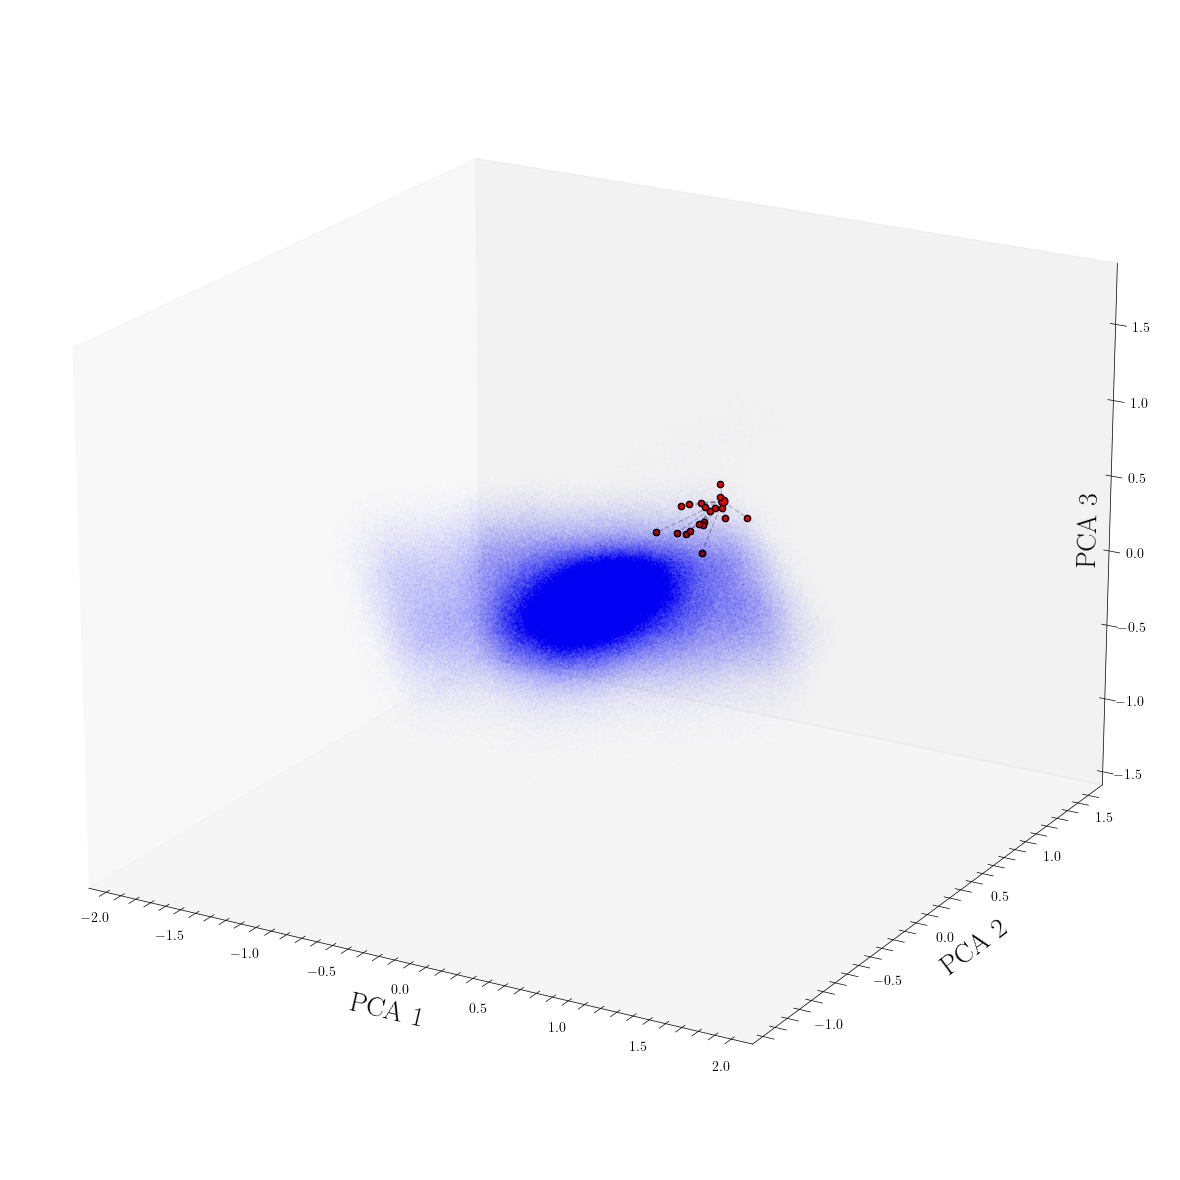

In [167]:
ax = plt.figure(figsize=(12,12)).add_subplot(projection='3d')

clst6_nn = pca[df[df["cluster"] == 6].index, :]
clst6 = df[df["cluster"] == 6]
clst6["rl"] = recon_losses[df[df["cluster"] == 6].index]
clst6["name"] = data.loc[clean_objs.iloc[df[df["cluster"] == 6].index, :].index, :]["fullDesignation"].values
clst6["e"] = clean_objs.iloc[df[df["cluster"] == 6].index, :]["e"].values
clst6 = clst6.sort_values(by="rl")


ax.scatter3D(
        clst6_nn[0, 0], 
        clst6_nn[0, 1],
        zs=clst6_nn[0, 2],
        c="red",
        edgecolor="black",
        s=40
    )

for i, name, e in zip(range(1,20), clst6["name"], clst6["e"]):
    ax.plot(
        [clst6_nn[0, 0], clst6_nn[i, 0]], 
        [clst6_nn[0, 1], clst6_nn[i, 1]],
        zs=[clst6_nn[0, 2], clst6_nn[i, 2]],
        c="black",
        alpha=.2,
        ls="--"
        )
    ax.scatter3D(
        clst6_nn[i, 0], 
        clst6_nn[i, 1],
        zs=clst6_nn[i, 2],
        c="r",
        edgecolor="black",
    )

ax.scatter(pca[:, 0], pca[:, 1], zs=pca[:, 2],alpha=.05,
    s=.001,
    marker="o",
    c="blue",
    )

ax.view_init(elev=20., azim=-60, roll=0)



ax.grid(True)
ax.set_facecolor("white")

plt.tight_layout()
plt.tight_layout()

ax.grid(False)
ax.set_xlabel('PCA 1', fontsize=20, labelpad=5)
ax.set_ylabel('PCA 2', fontsize=20, labelpad=5)
ax.set_zlabel('PCA 3', fontsize=20, labelpad=-30)

#plt.savefig("ISO_network_pca.png", dpi=300)
plt.show()

In [63]:
data.loc[clean_objs.iloc[np.argsort(recon_losses)[-10::][::-1], :].index, :]["q"].max()

5.847294294950474

Cluster 10

In [17]:
clean_objs.iloc[df[df["cluster"] == 10].index, :]#["incl"]

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,...,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
104881,66,0.899406,-341387.160000,2.498788e+11,38.219040,8.050334e+05,0.800775,-8.093015e+04,1.271962e+10,37.920116,...,69.388618,152.179950,24.690,13.513732,2.114210,-1.815286,0.494768,2.709550,3.941259,3.158691
615842,2114,1.148757,55.657726,1.315418e+02,28.838821,2.269747e+00,0.347762,2.887142e+07,3.402642e+13,37.108288,...,45.573235,301.739680,23.870,13.067312,-9.164719,0.895252,-8.323737,2.646569,3.733043,3.204700
884025,66,1.927554,-4655.166000,1.972120e+09,40.040550,4.672897e+05,1.097697,-2.215615e+04,9.060488e+09,38.487500,...,79.476429,212.866110,27.800,15.164350,-0.912590,2.465640,-0.272667,1.244279,1.614500,5.110697
1058549,2114,1.238892,5.558742,1.036118e+01,23.738276,1.670051e+00,1.175041,-8.657574e+04,9.322144e+09,35.605038,...,118.214779,221.919940,23.410,11.995716,-0.075983,-11.790779,-5.943475,2.529301,3.230236,3.384422
1625147,66,1.373680,-76353.310000,2.416536e+10,36.975708,3.474468e+05,0.569005,-3.861373e+05,1.501240e+11,39.579730,...,172.932718,172.938179,24.910,13.432286,1.099378,-3.703400,-1.258084,2.272412,3.543977,3.281453
2226418,66,1.587133,-417848.470000,3.169982e+11,34.993618,8.382416e+05,0.675385,-2.586181e+05,1.010888e+11,35.131725,...,144.539605,160.663962,24.683,10.476263,-0.095299,-0.042808,-0.674080,2.955640,4.673126,2.913246
2554344,66,0.694146,-85314.414000,1.774977e+10,36.427654,2.281727e+05,0.486915,-7.074669e+04,1.966789e+10,36.346294,...,33.418035,230.345550,23.860,15.366409,1.786914,-1.705554,0.252854,2.275360,2.910287,3.542340
2671142,2114,1.203739,9.701193,2.194556e-04,24.308092,1.755767e+00,1.037869,-6.172319e+04,8.336627e+09,35.092740,...,140.147597,204.655341,24.350,-2.165023,-0.574406,-10.210242,-5.675830,2.216840,3.161993,3.517601
2900157,66,0.589963,-765694.300000,8.360791e+11,39.547104,1.197674e+06,1.935119,7.372268e+04,1.386330e+09,36.241130,...,165.399369,163.194856,24.057,12.330457,1.126904,2.179070,1.413526,2.639055,4.668553,2.776481
3011264,66,0.709777,-24793.890000,1.354619e+09,37.475647,6.000131e+04,1.449192,-7.988212e+04,1.542675e+10,36.450214,...,136.278714,160.405220,24.005,11.614666,1.371457,-0.346024,0.494886,2.399177,4.541737,2.743197


Cluster 7

In [32]:
data.loc[clean_objs.iloc[df[df["cluster"] == 7].index, :].index, :]["fullDesignation"]

120122      2011 LPCC2232
152544     2011 S000004Ma
636997     2011 S000002fa
1369289     2011 LPCC3251
1893993     2011 1999 YN4
1936826      2011 2000 KB
2286376     2011 LPCC3684
2374646     2011 LPCC4755
2525687      2011 1987 QA
2560853    2011 1998 FH74
2774214      2011 1951 SX
2852657     2011 LPCC2613
2869753     2011 2005 GL9
3069427     2011 2005 LG8
3165286      2011 2000 OG
3236653    2011 S000008Da
3264608    2011 S000004Ta
3719402     2011 LPCC3750
4072577     2011 LPCC1712
4194501      2011 1985 PA
Name: fullDesignation, dtype: object

Cluster 8

In [18]:
clean_objs.iloc[df[df["cluster"] == 8].index, :].describe()

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,...,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
count,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2114.0,1.108135,0.615032,0.574120,16.579741,0.115409,1.061735,0.793765,0.665326,16.018072,...,86.293880,133.622038,16.026500,-0.285719,0.508794,0.052875,-0.093380,47.295386,89.769786,2.376102
std,0.0,0.430097,0.488898,0.311895,0.512393,0.049615,0.355340,0.709148,0.424151,0.456831,...,56.086689,51.054513,0.459247,0.679936,0.083622,0.119304,0.106328,161.168829,322.114736,1.480708
min,2114.0,0.478285,0.101176,0.210151,15.456729,0.046720,0.352826,-0.288150,0.253614,14.883480,...,5.085427,66.697000,15.000000,-2.272012,0.375708,-0.282917,-0.283234,5.145318,5.242992,-2.396188
25%,2114.0,0.836351,0.231609,0.364946,16.298507,0.080797,0.902344,0.269419,0.380551,15.786669,...,30.324669,88.696500,15.777500,-0.250943,0.449610,0.008659,-0.160996,5.173603,5.492752,2.793634
50%,2114.0,1.048020,0.423384,0.477469,16.654674,0.096404,1.029021,0.588298,0.606598,16.059629,...,75.249382,124.577883,16.110000,-0.020561,0.506150,0.076970,-0.072951,5.204287,5.626999,2.876801
75%,2114.0,1.325920,0.991418,0.751072,16.880693,0.139155,1.210040,1.208579,0.748332,16.347742,...,136.094179,172.072750,16.297500,0.053341,0.542078,0.126278,-0.026216,5.249373,5.839948,2.903700
max,2114.0,2.131669,1.607451,1.297059,17.390562,0.242931,1.870425,2.604219,2.113019,16.683037,...,201.804845,234.523000,16.710000,0.348348,0.690475,0.228088,0.101211,721.610957,1437.374620,2.959945


In [22]:
clean_objs.iloc[df[df["cluster"] == 8].index, :][clean_objs.iloc[df[df["cluster"] == 8].index, :]["Q"] > 10]#.describe()

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
212306,2114,1.978928,0.200003,0.885451,15.512159,0.202628,1.591640,0.200003,0.623344,14.883480,0.125043,14,1.458944,0.200003,0.570716,15.007925,0.124766,1.142421,0.487470,1.151098,4.403575,0.966285,14.891091,0.175548,160.781248,68.536038,216.683004,15.0,-0.007611,0.504234,0.124445,-0.065231,130.612040,256.820504,-2.396188
2748717,2114,1.434909,0.211117,0.862326,15.456729,0.156133,1.011393,2.604219,2.113019,15.266074,0.292348,14,1.682804,0.200001,0.619752,14.983157,0.123215,0.299646,9.327088,43.926560,5.847294,0.991897,15.737228,3.388040,119.030473,201.804845,122.478766,15.0,-0.471154,0.473572,-0.282917,-0.275834,721.610957,1437.374620,-1.444766


In [21]:
print(data.loc[clean_objs.iloc[df[df["cluster"] == 8].index, :].index, :]["fullDesignation"])

174079     2011 St500lcCa
186592     2011 St500aKWa
212306      2011 LPCC1411
254930     2011 St500b2Ka
665894     2011 St500gUla
1066990    2011 St500daCa
1402302    2011 St500dVba
1928102    2011 St500fuNa
2059919    2011 St500ahta
2078346    2011 St500iaVa
2086347    2011 St500kdMa
2748717     2011 LPCD1330
3020942    2011 St500ggma
3050269    2011 St500fS1a
3052517    2011 St500fcOa
3075674    2011 St500eW8a
3232253    2011 St5009mEa
3814386    2011 St500ecWa
4054896    2011 St500aATa
4137673    2011 St500hVTa
Name: fullDesignation, dtype: object


Cluster 2

In [39]:
pd.set_option('display.max_columns', None)
#print(data.loc[clean_objs.iloc[df[df["cluster"] == 2].index, :].index, :]["fullDesignation"])
clean_objs.iloc[df[df["cluster"] == 2].index, :].describe()

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
count,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,66.0,0.966632,12.228911,67.417085,24.846741,1.920123,1.155247,1.600139e+05,6.548669e+10,35.276536,185441.795800,14.500000,1.103684,-35090.850257,1.001067e+10,32.410792,136715.499068,0.897467,3.892427e+06,2.262516e+12,1.488657,0.410074,36.261873,447260.528500,13.126667,105.984119,180.393232,23.597550,-0.985337,-7.564052,-2.865743,-8.591590,2.549230,3.609802,3.301063
std,0.0,0.468617,36.050978,247.588026,1.466844,1.254696,0.589226,9.965042e+05,2.339053e+11,1.859018,129786.889482,4.861232,0.483259,47030.989858,2.141945e+10,3.717166,185847.954253,0.334500,1.703424e+07,9.407302e+12,0.448438,0.170238,2.059465,170768.905873,6.063206,40.292183,54.439887,0.980746,1.796657,3.024214,3.896535,1.515149,0.403379,0.823471,0.351150
min,66.0,0.207243,-1.504089,0.942083,22.468704,0.754730,0.389248,-3.225086e+05,4.920405e+08,32.252857,16751.960000,8.000000,0.097779,-179290.440000,7.048621e-02,23.700666,1.232687,0.225273,-6.698374e+05,4.967389e+09,0.531425,0.233066,33.020660,249199.440000,6.849810,53.382594,75.410060,22.420000,-4.534185,-12.385964,-12.430054,-11.744932,1.603284,2.339507,2.630066
25%,66.0,0.614852,0.568276,4.677179,23.810040,1.221477,0.635668,-8.292077e+04,2.776300e+09,34.134259,78509.825000,10.000000,0.801984,-40141.690750,7.678702e+07,31.643510,16873.821250,0.717093,-1.826097e+05,2.599354e+10,1.278440,0.277464,34.665409,294321.990000,8.213688,72.223447,147.014070,22.865000,-2.485438,-9.651026,-3.910594,-9.484477,2.332906,3.237164,3.213008
50%,66.0,0.932307,3.563301,9.102287,24.738376,1.496220,1.068593,-3.181193e+04,5.066734e+09,35.686495,180320.510000,13.500000,1.094518,-19507.613000,7.730274e+08,32.813885,53210.046500,0.873961,-1.142666e+05,6.718380e+10,1.582487,0.345146,36.039270,382809.795000,11.326730,103.388419,194.467990,23.500000,-0.794084,-7.952917,-1.271030,-8.716211,2.590684,3.438348,3.292864
75%,66.0,1.410703,7.737578,12.059541,25.978843,2.025305,1.663626,-2.039538e+04,2.319241e+10,36.110545,266814.067500,18.250000,1.384931,-5601.837250,5.146203e+09,34.167714,151742.492500,1.029042,-4.773754e+04,1.039699e+11,1.808945,0.483975,37.764148,593831.297500,16.225544,132.912519,216.118826,24.028750,0.306057,-5.880331,-0.492187,-7.476563,2.731842,3.809925,3.380731
max,66.0,1.757976,164.056080,1117.274800,28.033096,5.186626,2.264159,4.381610e+06,1.056366e+12,40.755558,420805.940000,26.000000,2.012700,5.887376,7.727586e+10,40.419060,634993.100000,1.602006,7.610640e+07,4.219848e+13,2.068381,0.791270,40.233345,755456.060000,27.489127,189.764461,270.909280,26.280000,2.514279,-1.231962,1.751703,-5.894404,3.364636,5.553665,4.189421


Cluster 7

In [19]:
clean_objs.iloc[df[df["cluster"] == 7].index, :].describe()

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,...,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
count,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,66.0,1122.927320,-0.703003,0.304232,16.853225,0.013734,1627.522326,0.825364,0.010944,15.969816,...,233.150120,171.947764,15.814800,-0.094862,0.671782,0.211628,0.123119,7.046013,13.441249,2.054671
std,0.0,1275.998560,8.819768,1.250704,1.124572,0.034895,2601.931049,0.872062,0.011118,0.719189,...,48.495083,65.384466,0.748097,0.452881,0.962891,0.357533,0.864047,50.172593,100.202955,2.386947
min,66.0,2.493002,-37.093650,0.001845,14.401682,0.001049,2.428917,-1.255984,0.001465,14.752678,...,152.694248,40.973248,15.000000,-1.015437,-0.480463,-0.819171,-0.835105,-179.994349,-360.183118,-1.370190
25%,66.0,33.072254,0.274276,0.006454,16.304367,0.002969,115.223628,0.389841,0.004028,15.444648,...,193.709515,131.464368,15.000000,-0.202220,0.416023,0.138306,-0.045292,1.668858,2.399029,-0.633962
50%,66.0,534.964120,0.556276,0.011629,17.003563,0.003548,349.172685,0.698722,0.006482,16.102801,...,229.558314,181.742870,15.910000,-0.061252,0.632829,0.209894,0.093686,2.005756,3.777627,2.950311
75%,66.0,2166.554225,1.375067,0.026122,17.345247,0.006251,1925.938400,1.489926,0.014304,16.521479,...,271.314773,200.978970,16.445000,-0.012491,0.725223,0.326398,0.154580,32.179954,63.141033,3.758327
max,66.0,3576.403300,9.102281,5.616153,19.925402,0.158251,11001.853000,2.506925,0.048670,17.159890,...,332.113088,307.478200,17.252000,1.338731,4.489297,0.895595,3.503398,74.847824,149.582768,6.261233


In [20]:
clean_objs.iloc[df[df["cluster"] == 7].index, :][clean_objs.iloc[df[df["cluster"] == 7].index, :]["q"] < 0.3075]

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,...,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
152544,66,1747.767800,1.465600,0.011932,17.310904,0.005030,421.70914,-0.157811,0.021204,17.031788,...,221.268745,185.821343,16.520,0.046095,-0.480463,0.759579,-0.655802,0.865878,1.682514,6.261233
636997,66,35.023956,0.299034,0.011327,16.372458,0.002073,24.10273,0.382445,0.006263,15.547156,...,152.694248,193.861871,15.586,-0.084112,0.634280,0.191022,0.080469,1.837195,3.497282,3.007614
2286376,66,1232.296400,0.200000,0.034894,15.737992,0.007523,1648.60850,1.578281,0.015150,15.489385,...,243.695660,217.391802,15.000,0.042608,0.310624,-0.062017,-0.321452,74.847824,149.582768,-0.346809
2560853,66,142.178700,0.154362,0.005648,16.681461,0.004722,276.63623,0.468724,0.004129,15.848385,...,193.409878,197.540010,15.790,-0.038907,0.593324,0.239752,0.065947,2.201070,4.147550,2.930584
2852657,66,830.204400,3.693202,0.004330,14.401682,0.005327,2091.23600,1.997243,0.002525,14.784737,...,180.625668,307.478200,15.000,0.345287,-0.185065,-0.197990,-0.823803,-179.994349,-360.183118,-0.532202
2869753,66,131.334720,0.909174,0.018265,17.543243,0.003018,20.10127,0.884645,0.006701,16.588003,...,162.240610,225.593410,16.660,-0.030857,0.740390,0.214850,0.185630,2.139972,4.057971,2.966111
3069427,66,111.063286,1.683765,0.006722,17.570896,0.003017,234.58954,1.666924,0.005200,16.669773,...,193.809394,211.295850,16.790,-0.174404,0.691460,0.209663,0.139748,1.755180,3.207696,3.548110
3264608,66,27.217146,0.307648,0.016565,17.448278,0.002931,145.59726,0.985430,0.009367,16.616236,...,332.113088,108.241690,16.548,-0.132898,0.678787,0.153255,0.103085,1.496269,2.848832,3.722448


In [45]:
print(data.loc[clean_objs.iloc[df[df["cluster"] == 7].index, :].index, :]["fullDesignation"])


120122      2011 LPCC2232
152544     2011 S000004Ma
636997     2011 S000002fa
1369289     2011 LPCC3251
1893993     2011 1999 YN4
1936826      2011 2000 KB
2286376     2011 LPCC3684
2374646     2011 LPCC4755
2525687      2011 1987 QA
2560853    2011 1998 FH74
2774214      2011 1951 SX
2852657     2011 LPCC2613
2869753     2011 2005 GL9
3069427     2011 2005 LG8
3165286      2011 2000 OG
3236653    2011 S000008Da
3264608    2011 S000004Ta
3719402     2011 LPCC3750
4072577     2011 LPCC1712
4194501      2011 1985 PA
Name: fullDesignation, dtype: object


Cluster 6

In [23]:
pd.set_option('display.max_columns', None)
print(data.loc[clean_objs.iloc[df[df["cluster"] == 6].index, :].index, :]["fullDesignation"])
clean_objs.iloc[df[df["cluster"] == 6].index, :]#.describe()

120122      2011 LPCC2232
152544     2011 S000004Ma
636997     2011 S000002fa
1369289     2011 LPCC3251
1893993     2011 1999 YN4
1936826      2011 2000 KB
2286376     2011 LPCC3684
2374646     2011 LPCC4755
2525687      2011 1987 QA
2560853    2011 1998 FH74
2774214      2011 1951 SX
2852657     2011 LPCC2613
2869753     2011 2005 GL9
3069427     2011 2005 LG8
3165286      2011 2000 OG
3236653    2011 S000008Da
3264608    2011 S000004Ta
3719402     2011 LPCC3750
4072577     2011 LPCC1712
4194501      2011 1985 PA
Name: fullDesignation, dtype: object


,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
120122,66,2819.713000,-37.093650,5.616153,19.925402,0.158251,19.384430,-0.040774,0.018898,15.262941,0.011332,34,433.557560,0.933657,0.006141,15.436105,0.001095,3260.993200,1.196260,0.009205,0.700241,0.987426,15.658614,0.003064,176.841442,241.474198,93.886953,15.000,-0.395673,4.489297,0.173164,3.503398,55.687885,110.675530,-0.939241
152544,66,1747.767800,1.465600,0.011932,17.310904,0.005030,421.709140,-0.157811,0.021204,17.031788,0.018331,57,735.201600,-0.860275,0.041332,17.791367,0.023030,208.329740,-0.034125,0.032750,0.049242,0.943131,16.985693,0.029596,22.167020,221.268745,185.821343,16.520,0.046095,-0.480463,0.759579,-0.655802,0.865878,1.682514,6.261233
636997,66,35.023956,0.299034,0.011327,16.372458,0.002073,24.102730,0.382445,0.006263,15.547156,0.001111,111,34.412550,0.409288,0.005765,15.738178,0.000978,16.700146,0.271252,0.014379,0.177107,0.903599,15.631268,0.002300,69.889042,152.694248,193.861871,15.586,-0.084112,0.634280,0.191022,0.080469,1.837195,3.497282,3.007614
1369289,66,1956.935900,9.102281,0.072899,16.480347,0.003364,3455.008800,0.392306,0.012412,15.310436,0.002634,12,8331.713000,0.747692,0.011431,15.937106,0.001707,4691.726000,-0.459907,0.026745,1.584060,0.955828,16.068039,0.016624,169.095838,284.654135,117.469581,15.000,-0.757603,0.543241,0.626670,0.195486,35.861428,70.138796,-1.370190
1893993,66,3576.403300,-0.003505,0.007147,17.197922,0.006863,1833.632900,0.124449,0.005320,16.170206,0.005723,39,6363.926300,0.116820,0.003417,16.440218,0.003601,484.598480,0.125684,0.006404,1.291198,0.233095,16.240190,0.006859,36.811760,242.603113,291.691510,16.030,-0.069984,0.757704,0.270012,0.225862,1.683648,2.076098,3.976586
1936826,66,4.213280,0.650511,0.023198,17.124620,0.003731,4.005602,0.456475,0.024992,16.271500,0.003448,94,8.475854,0.633767,0.016269,16.472380,0.002486,2.130524,0.360998,0.045543,0.468794,0.799309,16.324020,0.007377,56.200100,185.351950,185.367720,16.330,-0.052520,0.652240,0.200880,0.100890,2.335896,4.202999,2.675768
2286376,66,1232.296400,0.200000,0.034894,15.737992,0.007523,1648.608500,1.578281,0.015150,15.489385,0.001951,22,554.485900,-0.097235,0.004585,15.427368,0.001301,1045.498800,0.601992,0.007444,0.112880,0.998492,15.446777,0.001611,178.926742,243.695660,217.391802,15.000,0.042608,0.310624,-0.062017,-0.321452,74.847824,149.582768,-0.346809
2374646,66,2.493002,0.489805,0.116023,15.597859,0.015509,11001.853000,0.984609,0.006765,16.300713,0.003173,26,4833.606400,1.536986,0.003296,15.481542,0.002588,2.609973,0.431423,0.115659,1.097146,0.964554,14.961982,0.018434,174.910248,269.547419,40.973248,15.000,1.338731,0.116317,-0.819171,-0.835105,30.952796,60.808446,-1.113937
2525687,66,2795.409200,1.344890,0.006948,16.525436,0.006046,5101.395000,1.460474,0.003483,15.758666,0.003114,19,11828.251000,1.392630,0.003442,16.061878,0.002887,133.622600,1.438718,0.006481,0.874358,0.468629,15.697116,0.005041,40.723030,279.048254,169.160160,16.070,0.061550,0.463558,0.303212,-0.020988,1.645475,2.416592,3.915548
2560853,66,142.178700,0.154362,0.005648,16.681461,0.004722,276.636230,0.468724,0.004129,15.848385,0.000837,120,438.169740,0.181822,0.002806,16.088137,0.002486,95.452110,0.393390,0.007137,0.254590,0.884333,15.887292,0.001779,21.165010,193.409878,197.540010,15.790,-0.038907,0.593324,0.239752,0.065947,2.201070,4.147550,2.930584


Cluster 9

In [201]:
data.loc[clean_objs.iloc[df[df["cluster"] == 9].index, :].index, :][["fullDesignation", "q", "e", "incl", "a", "i_H", "i_HErr"]].describe()


,q,e,incl,a,i_H,i_HErr
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1.594246,0.967269,149.290769,85.210488,15.215515,0.012064
std,0.789058,0.023681,27.620461,107.731405,0.222102,0.014370
min,0.159622,0.928829,91.846238,34.096760,14.952848,0.001770
25%,0.904539,0.951923,137.345132,41.928878,15.070812,0.002978
50%,1.997049,0.961902,156.002554,46.909606,15.163199,0.006601
75%,2.219630,0.987908,170.185028,55.918668,15.271452,0.013210
max,2.459272,0.997023,179.000327,427.244838,15.764768,0.053573


Cluster 8

In [24]:
# Designations
print(data.loc[clean_objs.iloc[df[df["cluster"] == 8].index, :].index, :]["fullDesignation"])

174079     2011 St500lcCa
186592     2011 St500aKWa
212306      2011 LPCC1411
254930     2011 St500b2Ka
665894     2011 St500gUla
1066990    2011 St500daCa
1402302    2011 St500dVba
1928102    2011 St500fuNa
2059919    2011 St500ahta
2078346    2011 St500iaVa
2086347    2011 St500kdMa
2748717     2011 LPCD1330
3020942    2011 St500ggma
3050269    2011 St500fS1a
3052517    2011 St500fcOa
3075674    2011 St500eW8a
3232253    2011 St5009mEa
3814386    2011 St500ecWa
4054896    2011 St500aATa
4137673    2011 St500hVTa
Name: fullDesignation, dtype: object


In [24]:
cluster8 = clean_objs.iloc[df[df["cluster"] == 8].index]

In [25]:
# This filter is from pre-examining the labels
cluster8_asteroids = cluster8[cluster8["a"] < 5.5]

In [26]:
cluster8_asteroids.describe()

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
count,18.0,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2114.0,1.041604,0.660529,0.540812,16.701441,0.108301,1.035093,0.726171,0.587231,16.122883,0.119894,37.000000,1.065167,0.504114,0.359645,16.190437,0.070103,1.233861,4.379227,15.526727,4.787158,0.080367,16.413750,0.803790,20.354317,80.863151,129.626611,16.140556,-0.290867,0.511004,0.067554,-0.084807,5.204707,5.622256,2.853499
std,0.0,0.388810,0.495198,0.311386,0.369491,0.046398,0.351715,0.586233,0.266880,0.335599,0.051903,21.174346,0.208813,0.222859,0.160436,0.332523,0.032096,0.694235,9.980336,38.396019,0.263281,0.047169,0.821221,1.094393,7.161385,51.779864,49.831519,0.313021,0.714214,0.087954,0.093519,0.102729,0.042623,0.231338,0.103273
min,2114.0,0.478285,0.101176,0.210151,16.154678,0.046720,0.352826,-0.288150,0.253614,15.575965,0.044754,10.000000,0.606902,0.200002,0.192850,15.740170,0.030715,0.277805,-0.945239,0.399190,4.314516,0.011459,15.553645,0.164393,11.480700,5.085427,66.697000,15.670000,-2.272012,0.375708,-0.110990,-0.283234,5.145318,5.242992,2.516874
25%,2114.0,0.771783,0.304519,0.346519,16.347494,0.080316,0.898225,0.313642,0.376642,15.855257,0.079452,27.000000,1.029936,0.289969,0.269178,15.867744,0.048367,0.840087,0.045560,0.982229,4.612447,0.042275,16.048979,0.273585,15.892925,29.184706,88.597500,15.850000,-0.156670,0.443937,0.015736,-0.152048,5.171984,5.488218,2.816427
50%,2114.0,1.003418,0.472267,0.473786,16.691375,0.094813,1.029021,0.588298,0.566132,16.097749,0.115358,32.000000,1.105371,0.512374,0.297667,16.227434,0.056848,1.030506,0.200004,1.831364,4.803163,0.077001,16.164459,0.355452,17.878200,75.249382,121.396500,16.165000,-0.020561,0.518708,0.076970,-0.071604,5.197619,5.573985,2.894893
75%,2114.0,1.236177,1.089726,0.529924,16.910510,0.122611,1.185257,1.111314,0.729382,16.404337,0.144538,42.000000,1.153132,0.675567,0.416532,16.375527,0.087319,1.494121,1.804733,4.456368,5.010393,0.113848,16.480714,0.640335,24.480600,130.962602,164.132250,16.332500,0.074448,0.558054,0.125673,-0.024137,5.231699,5.794981,2.903942
max,2114.0,2.131669,1.607451,1.297059,17.390562,0.242931,1.870425,2.092808,1.235241,16.683037,0.225698,101.000000,1.501931,0.863183,0.807291,16.810928,0.160586,3.180899,36.932446,138.083500,5.154882,0.169079,18.521341,3.801807,40.580900,161.063802,234.523000,16.710000,0.348348,0.690475,0.228088,0.101211,5.286394,6.070381,2.959945


In [75]:
cluster8_comets = cluster8[cluster8["a"] > 5.5]

In [93]:
cluster8_comets

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
212306,2114,1.978928,0.200003,0.885451,15.512159,0.202628,1.591640,0.200003,0.623344,14.883480,0.125043,14,1.458944,0.200003,0.570716,15.007925,0.124766,1.142421,0.487470,1.151098,4.403575,0.966285,14.891091,0.175548,160.781248,68.536038,216.683004,15.0,-0.007611,0.504234,0.124445,-0.065231,130.612040,256.820504,-2.396188
2748717,2114,1.434909,0.211117,0.862326,15.456729,0.156133,1.011393,2.604219,2.113019,15.266074,0.292348,14,1.682804,0.200001,0.619752,14.983157,0.123215,0.299646,9.327088,43.926560,5.847294,0.991897,15.737228,3.388040,119.030473,201.804845,122.478766,15.0,-0.471154,0.473572,-0.282917,-0.275834,721.610957,1437.374620,-1.444766


In [27]:
trojans = clean_objs[(clean_objs["a"] < 5.21) & (clean_objs["a"] > 5.19)].describe()

In [92]:
np.sort(clean_objs[(clean_objs["a"] < 5.21) & (clean_objs["a"] > 5.19)]["incl"])[-100::]

array([44.6231, 44.6383, 45.3936, 45.471 , 45.6202, 46.3295, 49.4216,
       49.4753, 49.5064, 49.5393, 49.5923, 50.0501, 50.4828, 50.5099,
       50.6012, 50.9371, 50.9464, 51.2102, 51.3299, 51.7033, 51.7237,
       51.8048, 51.9209, 52.0078, 52.0282, 52.0642, 52.1157, 52.1735,
       52.1925, 52.2177, 52.3257, 52.3434, 52.7504, 52.8224, 52.8614,
       53.148 , 53.2469, 53.3021, 53.3357, 53.3735, 53.5257, 53.5495,
       53.6043, 53.7957, 53.8579, 53.8926, 53.9267, 54.0398, 54.0817,
       54.3053, 54.309 , 54.3752, 54.4284, 54.4708, 54.5038, 54.5126,
       54.7201, 54.7712, 54.8129, 54.8347, 55.0952, 55.2803, 55.3203,
       55.3528, 55.4042, 55.5109, 55.5906, 55.7811, 55.7983, 55.8105,
       55.8402, 55.9307, 55.9605, 55.9606, 55.9904, 56.1998, 56.6038,
       56.6095, 56.6257, 56.6342, 56.6415, 56.6471, 56.6958, 56.6969,
       56.7724, 56.816 , 56.8936, 56.9447, 56.9734, 57.0164, 57.0332,
       57.0357, 57.2993, 57.3154, 57.3301, 57.5131, 57.5357, 57.5451,
       57.5682, 57.6

In [83]:
np.sort(trojans["i-z"])

array([-4.70657000e+00, -5.17682500e-02, -3.26222297e-02,  6.35300000e-03,
        5.28922500e-02,  2.37819359e-01,  1.63580800e+00,  1.00110000e+04])

In [80]:
cluster8_asteroids.describe() - trojans

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
count,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000,-9993.000000
mean,2035.111777,-2.227443,0.026200,0.242303,1.011244,0.050883,-1.060427,0.082627,0.294533,1.020430,0.065420,-45.812706,-1.961974,-0.122177,0.184149,0.973387,0.037479,-0.258007,3.465923,10.307675,0.021515,-0.003171,1.278675,0.606690,4.446319,-104.830515,-46.617377,0.992702,-0.258245,0.037856,-0.047042,0.012523,0.004672,-0.012171,-0.037844
std,-161.961707,-20.756983,0.094368,-0.054454,-0.741100,-0.012608,-8.393491,0.101649,-0.603923,-0.773692,-0.025187,-39.258714,-15.608393,-0.079918,-0.234925,-0.772400,-0.000615,-3.150318,3.703817,-147.753001,0.035746,0.003442,-0.346633,0.154167,-1.943078,-50.677466,-49.399402,-0.791074,0.476395,0.006038,0.014886,0.031378,0.036850,0.004002,-0.015438
min,2048.000000,0.365146,3.142076,0.207783,7.313011,0.046407,0.286767,7.292350,0.251111,7.313697,0.044304,5.000000,0.225790,2.140708,0.190848,7.367855,0.030365,0.258123,100.250905,0.395383,0.670930,0.010009,7.293869,0.163754,11.339000,5.060786,66.643000,7.380000,2.434558,1.177721,1.167912,0.421423,-0.044688,0.036863,0.450994
25%,2048.000000,-0.173088,-0.086072,0.221867,1.159913,0.055867,-0.056721,-0.133309,0.268154,1.256385,0.059005,-23.000000,0.033832,-0.200731,0.192809,1.149577,0.034023,-0.023466,-0.154441,0.789116,-0.007437,-0.007986,1.452673,0.234675,6.182075,-69.328336,-6.169000,1.200000,-0.104902,0.008415,-0.071058,-0.020752,-0.023056,0.026577,-0.050096
50%,2048.000000,-0.158468,-0.143939,0.234435,0.666787,0.047414,-0.075890,-0.036024,0.349285,0.656640,0.072857,-42.000000,-0.048150,-0.115793,0.147411,0.665415,0.028496,-0.036280,-0.358424,1.414811,0.009198,-0.001049,0.741454,0.263807,3.442900,-116.779211,-55.023500,0.665000,-0.026914,0.048366,-0.041128,0.027652,-0.002311,-0.032248,-0.031527
75%,2048.000000,-0.266667,0.306756,0.143200,0.497627,0.047021,-0.125868,0.346475,0.370550,0.582386,0.074323,-59.000000,-0.261977,-0.061750,0.184797,0.434882,0.043200,0.191619,0.985050,3.553938,0.071193,0.002342,0.635393,0.449907,4.357300,-141.887762,-91.433750,0.462500,0.021556,0.052970,-0.022872,0.044318,0.026662,0.015439,-0.059884
max,0.000000,-873.285571,-7.232468,-13.440249,-1.504338,-2.432357,-273.898875,-25.592042,-67.068325,-2.484497,-3.679647,-862.000000,-428.312099,-15.296781,-34.395983,-2.209272,-1.675472,-98.789011,-341.849784,-14589.053500,-0.043227,-0.130888,-3.214653,-52.842457,-17.060400,-198.882790,-125.472000,-1.130000,-1.287460,-0.952550,-1.242317,-0.829667,0.076400,-0.695786,-0.039883


Cluster 9

In [94]:
print(data.loc[clean_objs.iloc[df[df["cluster"] == 9].index, :].index, :]["fullDesignation"])

18210      2011 LPCC1853
580734      2011 LPCC848
778670       2011 LPCC76
1101335    2011 LPCC2375
2058571    2011 LPCC2989
2123855    2011 LPCC4658
2259072    2011 LPCC2602
2455515     2011 LPCC570
2508079    2011 LPCC3564
2557085    2011 LPCC4721
2624711      2011 LPCC26
2746140    2011 LPCC4010
2788946    2011 LPCC4687
2929055    2011 LPCC3189
3500507    2011 LPCC4129
3718119    2011 LPCC2758
3908050    2011 LPCC2353
4061068    2011 LPCC1434
4292641    2011 LPCC1151
4344516    2011 LPCC2991
Name: fullDesignation, dtype: object


In [96]:
clean_objs.iloc[df[df["cluster"] == 9].index, :].describe()

,flags,g_Chi2,g_G12,g_G12Err,g_H,g_HErr,i_Chi2,i_G12,i_G12Err,i_H,i_HErr,i_Ndata,r_Chi2,r_G12,r_G12Err,r_H,r_HErr,z_Chi2,z_G12,z_G12Err,q,e,z_H,z_HErr,incl,peri,node,mpcH,i-z,g-r,r-i,a*,a,Q,T_jup
count,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,66.0,2676.655025,-0.654735,0.577259,16.144013,0.036562,107.994895,0.567001,0.050685,15.215515,0.012064,25.650000,518.383445,0.619203,0.041703,15.309602,0.006991,70.689158,0.356800,0.097999,1.594246,0.967269,15.285428,0.038371,149.290769,207.861281,21.312483,15.0,-0.069913,0.834411,0.094087,0.214965,85.210488,168.826730,-1.104034
std,0.0,7944.495909,5.297127,2.160719,1.260347,0.096584,165.229937,0.736565,0.076501,0.222102,0.014370,10.624079,1755.434577,0.801577,0.035550,0.291011,0.005651,81.261290,0.733322,0.131251,0.789058,0.023681,0.391427,0.066452,27.620461,64.092072,20.690196,0.0,0.315624,1.248207,0.203046,1.116046,107.731405,215.500757,0.631295
min,66.0,0.567802,-22.485647,0.005309,15.535372,0.002445,0.881649,-0.532366,0.003052,14.952848,0.001770,11.000000,0.827563,-1.533764,0.003899,15.090473,0.001374,0.741831,-1.014699,0.006182,0.159622,0.928829,14.879224,0.003733,91.846238,100.270111,0.399149,15.0,-1.339712,0.283036,-0.529862,-0.410883,34.096760,65.766819,-1.780117
25%,66.0,0.993664,0.201463,0.019081,15.594127,0.005094,9.584181,0.136136,0.014843,15.070812,0.002978,18.250000,3.563911,0.256500,0.012699,15.130265,0.002506,5.277431,0.076741,0.032470,0.904539,0.951923,15.038214,0.006176,137.345132,164.493777,8.811236,15.0,-0.054161,0.421769,0.015685,-0.154151,41.928878,81.616610,-1.603280
50%,66.0,34.540114,0.534736,0.055056,15.730372,0.008910,52.064138,0.551214,0.020452,15.163199,0.006601,23.500000,75.744773,0.491983,0.023618,15.232453,0.005279,48.124018,0.289668,0.047969,1.997049,0.961902,15.192521,0.016899,156.002554,221.938722,16.002728,15.0,0.001747,0.482205,0.115702,-0.104146,46.909606,92.777121,-1.352974
75%,66.0,230.806800,1.421155,0.142763,15.924995,0.020218,118.989583,0.862382,0.068981,15.271452,0.013210,33.500000,247.565245,0.961244,0.069110,15.366490,0.010206,119.638461,0.549318,0.120139,2.219630,0.987908,15.362633,0.036009,170.185028,247.661081,24.437849,15.0,0.058396,0.599348,0.150329,0.043376,55.918668,110.899643,-0.701189
max,66.0,27335.600000,1.835107,9.747620,21.103336,0.441245,674.099900,2.177259,0.341021,15.764768,0.053573,52.000000,7947.749000,2.434863,0.105630,16.397380,0.023865,288.744570,1.836336,0.587850,2.459272,0.997023,16.521420,0.291881,179.000327,338.601627,89.814789,15.0,0.156585,6.012863,0.632612,4.789182,427.244838,853.217839,0.054097


In [136]:
for i in range(1, 11):    
    print(clean_objs.iloc[df[df["cluster"] == i].index, :].describe())
    print(data.loc[clean_objs.iloc[df[df["cluster"] == i].index, :].index, :]["fullDesignation"])
    print("------")

       flags     g_Chi2         g_G12      g_G12Err        g_H        g_HErr  \
count   20.0  20.000000  2.000000e+01  2.000000e+01  20.000000  2.000000e+01   
mean    66.0   1.296459 -6.859294e+03  1.636350e+11  37.151981  5.618284e+05   
std      0.0   0.566964  6.950250e+05  2.692678e+11   2.768058  4.095009e+05   
min     66.0   0.421167 -5.816593e+05  1.858375e+08  33.832245  4.291813e+04   
25%     66.0   0.798389 -1.791419e+05  2.081065e+10  35.324715  3.361588e+05   
50%     66.0   1.251299 -1.343738e+05  4.265749e+10  37.190398  4.209186e+05   
75%     66.0   1.639845 -5.165506e+04  1.753757e+11  37.935974  6.033546e+05   
max     66.0   2.376375  2.886466e+06  9.056705e+11  45.602300  1.713263e+06   

          i_Chi2         i_G12      i_G12Err        i_H  ...        peri  \
count  20.000000  2.000000e+01  2.000000e+01  20.000000  ...   20.000000   
mean    1.207512  3.740525e+06  5.111106e+12  36.132480  ...  165.289830   
std     0.626623  1.692823e+07  2.250366e+13   1.71